In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np

import catboost as cat
import xgboost as xgb

from collections import Counter


from scipy.fft import fft, fftfreq
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from sklearn.metrics import confusion_matrix

from sklearn.cluster import OPTICS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel

import kerastuner as kt

from bayes_opt import BayesianOptimization

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_47897/220924193.py:36: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [6]:
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(targets, predictions):
    cm = confusion_matrix(targets, predictions)

    # Plot confusion matrix
    _, ax = plt.subplots(figsize=(8, 6))
    sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_xlabel("Predicted Quintile")
    ax.set_ylabel("Actual Quintile")
    ax.set_title("Confusion Matrix")
    plt.show()

In [7]:
import json
from typing import Any, Optional
from dataclasses import dataclass
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score


def custom_metric(target, prediction):
    mask = ((prediction == 'top') | (prediction == 'bottom'))
    valid_predictions = mask.sum()
    
    return 0 if valid_predictions == 0 else ((target == prediction) & mask).sum() / mask.sum()


@dataclass
class ModelOptimizer:
    model_class: Any
    pbounds: dict
    X: pd.DataFrame
    y: pd.DataFrame
    X_val: pd.DataFrame
    y_val: pd.DataFrame
    verbose: bool = False
    extra_params: Optional[dict] = None
    force_params: Optional[dict] = None
    captured_data: Optional[dict] = None

    @staticmethod
    def get_int_params():
        return [
            "n_estimators", "max_depth", "min_samples_split", "min_samples_leaf",
            "iterations", "depth", "early_stopping_rounds", "max_samples"
        ]

    @staticmethod
    def process_params(params: dict, dtypes: Optional[dict] = None) -> dict:
        for k, v in params.items():
            if dtypes is not None and k in dtypes:
                params[k] = dtypes[k](v)
            elif k in ModelOptimizer.get_int_params():
                params[k] = int(round(v))
        return params

    def catboost_performance(self, **params):
        model: cat.CatBoostClassifier = self.model_class(**params)
        model.fit(
            cat.Pool(self.X, self.y),
            eval_set=cat.Pool(self.X_val, self.y_val),
            plot=False
        )
        y_pred = model.predict(self.X_val)

        return custom_metric(self.y_val.to_numpy(), y_pred.flatten())

    def xgb_performance(self, **params):
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(self.y)
        y_val_encoded = le.transform(self.y_val)

        model = self.model_class(**params)
        model.fit(
            self.X, y_train_encoded,
            eval_set=[(self.X_val, y_val_encoded)],
            verbose=False
        )
        y_pred = model.predict(self.X_val)

        return custom_metric(
            le.inverse_transform(y_val_encoded),
            le.inverse_transform(y_pred)
        )

    def sklearn_performance(self, **params):
        model = self.model_class(**params)
        model.fit(self.X, self.y)
        y_pred = model.predict(self.X_val)

        return accuracy_score(self.y_val, y_pred) # custom_metric(self.y_val, y_pred)

    def cv_performance(self, **params) -> float:
        params = ModelOptimizer.process_params(params, dtypes=self.force_params)
        for k, v in self.extra_params.items(): params[k] = v
        if self.verbose: print(json.dumps(params, indent=4))
        
        if self.model_class == cat.CatBoostClassifier:
            return self.catboost_performance(**params)
        elif self.model_class == xgb.XGBClassifier:
            return self.xgb_performance(**params)
        else:
            return self.sklearn_performance(**params)
    
    def add_permanent_params(self):
        if self.extra_params is None: self.extra_params = {}

        if self.model_class in [cat.CatBoostClassifier]:
            # self.extra_params['loss_function'] = 'RMSE'
            self.extra_params['iterations'] = 20000
            self.extra_params['early_stopping_rounds'] = 300
            self.extra_params['eval_metric'] = "Accuracy"
            self.extra_params['verbose'] = False

        elif self.model_class in [xgb.XGBClassifier]:
            self.extra_params['n_estimators'] = 10000
            self.extra_params['early_stopping_rounds'] = 50
            self.extra_params['eval_metric'] = "mlogloss"

        elif self.model_class in [RandomForestClassifier]:
            self.extra_params['n_jobs'] = -1
            self.extra_params['verbose'] = False

    def get_final_params(self, params: dict) -> dict:
        params = ModelOptimizer.process_params(params, dtypes=self.force_params)
        self.add_permanent_params()
        for k, v in self.extra_params.items(): params[k] = v
        return params

    def optimize_model(self) -> dict:
        self.add_permanent_params()

        optimizer = BayesianOptimization(
            f=self.cv_performance,
            pbounds=self.pbounds,
            random_state=42,
        )

        optimizer.maximize(init_points=10, n_iter=25)
        return optimizer.max

In [8]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    return accuracy, precision, recall, f1

def calculate_proportions(array):
    counts = Counter(array)
    total = array.shape[0]
    proportions = {key: val / total for key, val in counts.items()}
    return proportions

def classification_report(predictions, targets, class_names):
    # Calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(targets, predictions)

    # Calculate proportions
    pred_proportions = calculate_proportions(predictions)
    target_proportions = calculate_proportions(targets)

    # Map class indices to class names
    index_to_class_name = {index: class_name for index, class_name in enumerate(class_names)}

    # Print the results
    print(f"Accuracy: {accuracy * 100:.2f}%")

    data = []
    for class_index, class_name in index_to_class_name.items():
        pred_proportion = pred_proportions.get(class_index, -1)
        pred_proportion = pred_proportions.get(class_name, 0) * 100 if pred_proportion == -1 else pred_proportion * 100
        
        target_proportion = target_proportions.get(class_index, -1)
        target_proportion = target_proportions.get(class_name, 0) * 100 if target_proportion == -1 else target_proportion * 100

        row = {
            'Class': class_name,
            'Precision': precision[class_index] * 100,
            'Recall': recall[class_index] * 100,
            'F1-score': f1[class_index] * 100,
            'Prediction Proportion': pred_proportion,
            'Target Proportion': target_proportion,
        }
        data.append(row)

    return pd.DataFrame(data)

In [9]:
import seaborn as sns

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    sns.set_style('whitegrid')
    sns.set_palette('husl')

    # Left plot (Accuracy)
    sns.lineplot(data=history.history['accuracy'], ax=ax1)
    sns.lineplot(data=history.history['val_accuracy'], ax=ax1)

    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='both', labelsize=10)
    ax1.legend(['Training', 'Validation'], loc='lower right', fontsize=10)

    # Right plot (Loss)
    sns.lineplot(data=history.history['loss'], ax=ax2)
    sns.lineplot(data=history.history['val_loss'], ax=ax2)

    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='both', labelsize=10)
    ax2.legend(['Training', 'Validation'], loc='upper right', fontsize=10)

    plt.show()


# Importación del dataset final

In [14]:
df = pd.read_csv('./final_dataset_daily.csv').drop(columns=['Unnamed: 0'])
df['t'] = pd.to_datetime(df['t'])
df = df.set_index(['t', 'symbol'])
df = df.sort_index()
df.head()

,,o,h,l,c,v,n,vw,emaS,emaM,emaL,...,time_embed_month_sin,time_embed_month_cos,time_embed_year_sin,time_embed_year_cos,market_correlation,market_long_term_trend,market_short_term_trend,market_change,alpha,beta
t,symbol,,,,,,,,,,,,,,,,,,,,,
2018-01-02,BABA,173.46,184.1000,172.43,183.93,30309800,191226,179.269037,1.012149,1.002620,1.000697,...,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,BABA,183.95,185.7800,181.40,183.85,20011104,136275,183.777505,1.016482,1.004765,1.001499,...,0.207912,0.978148,0.017213,0.999852,1.000000,1.006064,1.006064,NaN,NaN,NaN
2018-01-04,BABA,183.85,187.7472,183.85,185.80,19451778,133778,185.511399,1.014133,1.005210,1.001759,...,0.406737,0.913545,0.034422,0.999407,0.963117,1.006269,1.006284,0.697924,NaN,NaN
2018-01-05,BABA,185.80,190.7800,185.80,190.70,18149493,122317,188.256131,1.014354,1.006123,1.002187,...,0.587785,0.809017,0.051620,0.998667,0.982457,1.005670,1.005585,-1.111019,NaN,NaN
2018-01-06,BABA,190.78,190.9000,190.71,190.71,9943,87,190.834919,1.014135,1.006844,1.002564,...,0.743145,0.669131,0.068802,0.997630,0.988348,1.005110,1.004919,-1.157179,NaN,NaN


Magnitud media de la variación de TSLA a través del tiempo

<AxesSubplot:xlabel='t,symbol'>

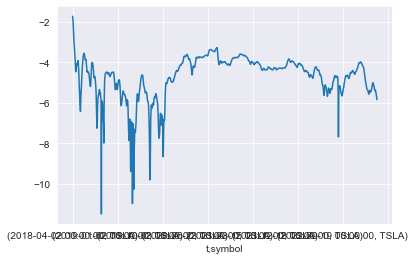

In [15]:
np.log(df.groupby('symbol').get_group('TSLA').ewm(span=500).mean().abs()['pc12']).plot()

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_47897/894472347.py:6: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['symbol'], dtype='object')
  data = np.log(df.groupby('symbol').get_group('TSLA').reset_index().set_index('t').ewm(span=500).mean().abs()['pc12'])


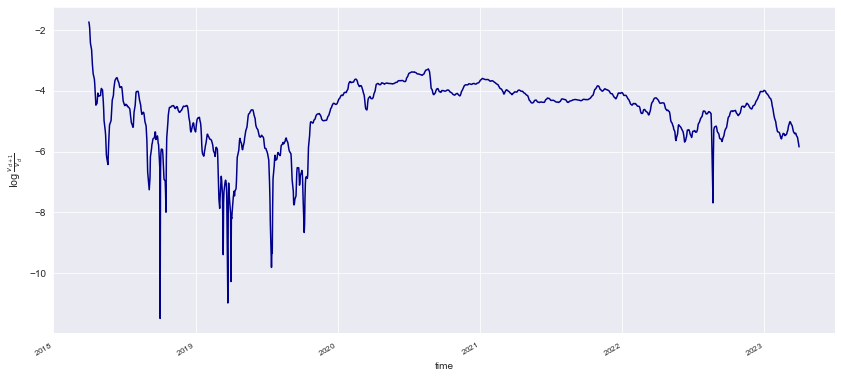

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('text', usetex=False)
sns.set_style('darkgrid')
data = np.log(df.groupby('symbol').get_group('TSLA').reset_index().set_index('t').ewm(span=500).mean().abs()['pc12'])
plt.figure(figsize=(14, 6)) # Increase the figure size to 10x6 inches
plt.xticks(rotation=30, ha='right', fontsize=8)
plt.xlabel('time')

plt.rc('text', usetex=True)
plt.ylabel(r'$\log{\frac{v_{d+1}}{v_d}}$')
sns.lineplot(data=data, color='darkblue') # Set the line colour to dark blue
plt.rc('text', usetex=False)

<AxesSubplot:>

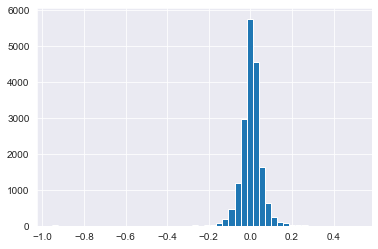

In [17]:
df['pc12'].hist(bins=50)

Top 20 valores PC12

In [18]:
df.reset_index()
df = df.sort_values('pc12')
df['pc12'].head(20)

t           symbol
2022-06-03  AMZN     -0.954587
2022-07-11  GOOG     -0.952259
2022-06-02  AMZN     -0.951967
2022-07-12  GOOG     -0.951297
2022-07-15  GOOG     -0.951033
2022-06-01  AMZN     -0.949984
2022-07-13  GOOG     -0.949214
2022-07-14  GOOG     -0.948736
2022-05-31  AMZN     -0.948128
2022-05-27  AMZN     -0.944955
2020-08-28  TSLA     -0.822320
2020-08-27  TSLA     -0.813720
2020-08-26  TSLA     -0.783359
2021-07-13  NVDA     -0.771063
2020-08-24  TSLA     -0.766312
2020-08-28  AAPL     -0.762431
2021-07-14  NVDA     -0.761341
2020-08-27  AAPL     -0.752944
2020-08-25  TSLA     -0.752520
2021-07-15  NVDA     -0.747555
Name: pc12, dtype: float64

Bottom 5 valores PC12

In [19]:
df['pc12'].tail()

t           symbol
2020-04-06  TSLA      0.399913
2020-06-29  TSLA      0.412180
2020-03-18  TSLA      0.434142
2020-01-29  TSLA      0.499866
2022-03-15  BABA      0.509511
Name: pc12, dtype: float64

## Metodo de categorización 1
Este es el malo, calcula los percentiles generales y agrupa cada instancia en su respectivo grupo

In [20]:
df.sort_values('pc12')
top_value = df['pc12'].quantile(0.95)
bottom_value = df['pc12'].quantile(0.05)

df['category'] = 'middle'
df.loc[df['pc12'] > top_value, 'category'] = 'top'
df.loc[df['pc12'] < bottom_value, 'category'] = 'bottom'

## Metodo 2
Este es el bueno, calcula unos thresholds dinamicos en función de la aproximación de la función de distribución gaussiana para detectar el top 5% y bottom 5% de las instancias de manera contextual. És decir, que en función del contexto del activo en cada momento estima cuales són los valores más extremos que pueden suceder.

In [21]:
from scipy.stats import norm
df = df.sort_index()

# Define the threshold percentile
threshold_percentile = 4
rolling_window = 77

# Compute the rolling mean and standard deviation for each symbol
df['rolling_mean'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).mean())
df['rolling_std'] = df.groupby('symbol')['pc12'].transform(lambda x: x.rolling(window=rolling_window).std())

# Compute the upper and lower threshold values for each symbol
df['upper_threshold'] = df['rolling_mean'] + df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)
df['lower_threshold'] = df['rolling_mean'] - df['rolling_std'] * norm.ppf(1 - threshold_percentile / 100)

# Assign the category based on the thresholds
df['category'] = 'middle'
df.loc[df['pc12'] > df['upper_threshold'], 'category'] = 'top'
df.loc[df['pc12'] < df['lower_threshold'], 'category'] = 'bottom'

df['category'] = df['category'].astype('category')

# Drop the intermediate columns
df.drop(['rolling_mean', 'rolling_std', 'upper_threshold', 'lower_threshold'], axis=1, inplace=True)

Porcentages finales de cada clase:

In [22]:
year = 2022
res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])

res['middle']

90.17786036633926

In [23]:
amounts = {
    'top': [],
    'middle': [],
    'bottom': [],
}
for year in [2018, 2019, 2020, 2021, 2022, 2023]:
    res = df[df.index.get_level_values('t').year == year].value_counts('category') * 100 / len(df[df.index.get_level_values('t').year == year])
    amounts['top'].append(res['top'])
    amounts['middle'].append(res['middle'])
    amounts['bottom'].append(res['bottom'])

res = df.value_counts('category')

print(f"Mean of 'top' values by year:    {np.mean(amounts['top']):.3f}%")
print(f"Std of 'top' values by year:     {np.std(amounts['top']):.3f}%")

print(f"\nMean of 'middle' values by year: {np.mean(amounts['middle']):.3f}%")
print(f"Std of 'middle' values by year:  {np.std(amounts['middle']):.3f}%")

print(f"\nMean of 'bottom' values by year: {np.mean(amounts['bottom']):.3f}%")
print(f"Std of 'bottom' values by year:  {np.std(amounts['bottom']):.3f}%")

Mean of 'top' values by year:    4.490%
Std of 'top' values by year:     1.151%

Mean of 'middle' values by year: 90.408%
Std of 'middle' values by year:  1.988%

Mean of 'bottom' values by year: 5.102%
Std of 'bottom' values by year:  1.458%


In [24]:
df.columns

Index(['o', 'h', 'l', 'c', 'v', 'n', 'vw', 'emaS', 'emaM', 'emaL', 'std', 'pc',
       'pc12', 'mvS', 'mvL', 'mnS', 'mnL', 'rsi', 'rsid', 'rlmS', 'rlmL',
       'rlmD', 'obvSH', 'avgv', 'macds', 'financial_data_age', 'P/E', 'P/S',
       'P/B', 'EPS_Growth', 'ROE', 'ROA', 'Gross_Margin', 'Operating_Margin',
       'Net_Profit_Margin', 'Current_Ratio', 'Debt_to_Equity', 'FCF',
       'spy_value', 'time_embed_week_sin', 'time_embed_week_cos',
       'time_embed_month_sin', 'time_embed_month_cos', 'time_embed_year_sin',
       'time_embed_year_cos', 'market_correlation', 'market_long_term_trend',
       'market_short_term_trend', 'market_change', 'alpha', 'beta',
       'category'],
      dtype='object')

---

# Preparación del dataset

Primero se calcula el punto en el que dividir el dataset a partir de un threshold temporal que divida en un 80/20 el rango general de timestamps del dataset

In [25]:
# Codigo para detectar altas variaciones
df['hv_cat'] = 0
df['hv_cat'].loc[(df['category'] == 'bottom') | (df['category'] == 'top')] = 1

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_47897/3322020656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hv_cat'].loc[(df['category'] == 'bottom') | (df['category'] == 'top')] = 1


In [26]:
df['category'].value_counts()

middle    16377
bottom      952
top         795
Name: category, dtype: int64

In [27]:
df['hv_cat'].value_counts()

0    16377
1     1747
Name: hv_cat, dtype: int64

In [28]:
df.index.get_level_values('t').min()
df.index.get_level_values('t').max()

timestamps = df.index.get_level_values('t')
min_timestamp = timestamps.min()
max_timestamp = timestamps.max()

# Find the timestamp that is 80% of the way between the min and max
threshold_timestamp_val = min_timestamp + 0.6 * (max_timestamp - min_timestamp)
threshold_timestamp_test = min_timestamp + 0.85 * (max_timestamp - min_timestamp)
print("60% division timestamp:", threshold_timestamp_val)
print("85% division timestamp:", threshold_timestamp_test)

60% division timestamp: 2021-02-23 09:36:00
85% division timestamp: 2022-06-16 21:36:00


Aquí se puede hacer una primera selección de atributos aunque de momento no se haga nada :)

In [29]:
"""
columns = [
    'pc', 'emaL', 'emaS', 'mvS', 'rsi', 'macds', 'lavs', 'Net_Profit_Margin', 'market_correlation',
    'Gross_Margin', 'P/E', 'time_embed_year_sin', 'time_embed_year_cos', 'financial_data_age', 'obvmL'
]
"""
columns = df.columns

Aqui se divide ya el dataset separando los dataframes directamente en vez de hacerlo con el classico train/test split de toda la vida. Esto es así ya que se desea preprocesar el data_train por separado.

In [30]:
data = df[columns].dropna()
data_train = data[data.index.get_level_values('t') <= threshold_timestamp_val]
data_val = data[(data.index.get_level_values('t') > threshold_timestamp_val) & (data.index.get_level_values('t') <= threshold_timestamp_test)]
data_test = data[data.index.get_level_values('t') > threshold_timestamp_test]

In [31]:
X_train_raw = data_train[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_train = data_train['category']

X_val_raw = data_val[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_val = data_val['category']

X_test_raw = data_test[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_test = data_test['category']

labels_scaler = StandardScaler()
X_train = pd.DataFrame(labels_scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_val = pd.DataFrame(labels_scaler.transform(X_val_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(labels_scaler.transform(X_test_raw), columns=X_train_raw.columns)

# targets_scaler = StandardScaler()
# y_train_scaled = targets_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
# y_test_scaled = targets_scaler.transform(y_test.to_numpy().reshape(-1, 1))

print("Train:")
print(X_train.shape)
print(y_train.shape)
print("\nValidation:")
print(X_val.shape)
print(y_val.shape)
print("\nTest:")
print(X_test.shape)
print(y_test.shape)

Train:
(8359, 50)
(8359,)

Validation:
(4217, 50)
(4217,)

Test:
(2588, 50)
(2588,)


In [32]:
X_train_raw = data_train[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_train_hv = data_train['hv_cat']

X_val_raw = data_val[columns].drop(columns=['pc12', 'category', 'hv_cat'])
y_val_hv = data_val['hv_cat']

y_test_hv = data_test['hv_cat']

X_train_hv = pd.DataFrame(labels_scaler.transform(X_train_raw), columns=X_train_raw.columns)
X_val_hv = pd.DataFrame(labels_scaler.transform(X_val_raw), columns=X_train_raw.columns)

print("Train:")
print(X_train_hv.shape)
print(y_train_hv.shape)
print("\nValidation:")
print(X_val_hv.shape)
print(y_val_hv.shape)
print("\nTest:")
print(X_test.shape)
print(y_test_hv.shape)

Train:
(8359, 50)
(8359,)

Validation:
(4217, 50)
(4217,)

Test:
(2588, 50)
(2588,)


In [33]:
X_train.isna().sum().sort_values()

o                          0
P/B                        0
EPS_Growth                 0
ROE                        0
ROA                        0
Gross_Margin               0
Operating_Margin           0
Net_Profit_Margin          0
Current_Ratio              0
Debt_to_Equity             0
FCF                        0
spy_value                  0
time_embed_week_sin        0
time_embed_week_cos        0
time_embed_month_sin       0
time_embed_month_cos       0
time_embed_year_sin        0
time_embed_year_cos        0
market_correlation         0
market_long_term_trend     0
market_short_term_trend    0
market_change              0
P/S                        0
P/E                        0
financial_data_age         0
macds                      0
h                          0
l                          0
c                          0
v                          0
n                          0
vw                         0
emaS                       0
emaM                       0
emaL          

Se prepara y entrena un Random Forest basico

In [126]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    verbose=True,
    class_weight='balanced',
    random_state=42
)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Se visualiza la matriz de confusión

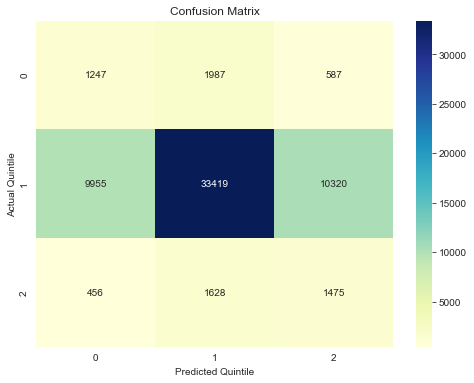

Accuracy: 59.18%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,bottom,10.696517,32.635436,16.112152,19.088319,6.256345
1,middle,90.238700,62.239729,73.668548,60.637915,87.916298
2,top,11.912454,41.444226,18.505740,20.273766,5.827357


In [155]:
plot_confusion_matrix(y_val, y_pred)
classification_report(pd.Series(y_pred), pd.Series(y_val), ['bottom', 'middle', 'top'])

In [294]:
rfhv_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    verbose=True,
    n_jobs=-1,
)
rfhv_classifier.fit(X_train, y_train_hv)
y_pred_hv = rfhv_classifier.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


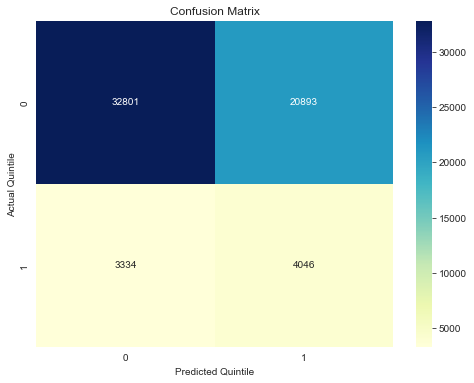

Accuracy: 60.33%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,90.773488,61.088762,73.029868,59.16593,87.916298
1,1,16.223586,54.823848,25.037903,40.83407,12.083702


In [295]:
plot_confusion_matrix(y_val_hv, y_pred_hv)
classification_report(y_pred_hv, y_val_hv, [0, 1])

In [296]:
y_pred_prob = rf_classifier.predict_proba(X_val)
y_pred_prob

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


array([[0.16190176, 0.62584421, 0.21225403],
       [0.19098721, 0.57854412, 0.23046867],
       [0.15749374, 0.5156763 , 0.32682996],
       ...,
       [0.14024859, 0.35371046, 0.50604095],
       [0.16072958, 0.54420135, 0.29506907],
       [0.11845437, 0.30177086, 0.57977478]])

In [297]:
np.argmax(y_pred_prob, axis=1) == 0

array([False, False, False, ..., False, False, False])

In [199]:
def classify_probabilities(th_bottom, th_top, probabilities):
    pred_ids = np.argmax(probabilities, axis=1)
    pred = pd.Series(['middle'] * len(pred_ids))
    pred[pred_ids == 0] = 'bottom'
    pred[pred_ids == 2] = 'top'

    b_mask = (pred_ids == 0)
    t_mask = (pred_ids == 2)

    pred[b_mask & (probabilities[:, 0] <= th_bottom)] = 'middle'
    pred[t_mask & (probabilities[:, 2] <= th_top)] = 'middle'

    return pred

In [308]:
@dataclass
class MetricComputer:
    predicted_probabilities: pd.Series
    targets: pd.Series

    def compute_metric(self, threshold_bottom, threshold_top):
        pred_ids = np.argmax(self.predicted_probabilities, axis=1)
        pred = pd.Series(['middle'] * len(pred_ids))
        pred[pred_ids == 0] = 'bottom'
        pred[pred_ids == 2] = 'top'

        b_mask = (pred_ids == 0)
        t_mask = (pred_ids == 2)

        pred[b_mask & (self.predicted_probabilities[:, 0] <= threshold_bottom)] = 'middle'
        pred[t_mask & (self.predicted_probabilities[:, 2] <= threshold_top)] = 'middle'

        targ = self.targets

        mask = (pred == 'top') | (pred == 'bottom')
        tb_precision = (mask & (targ == pred)).sum() / mask.sum() if mask.sum() > 0 else 0
        m_recall = (~mask & (pred == targ)).sum() / (targ == 'middle').sum()

        # return np.average(f1_score(targ, pred, average=None)[[True, False, True]])
        return tb_precision * m_recall * mask.sum()

In [309]:
MetricComputer(y_pred_prob, y_val.reset_index()['category']).compute_metric(0.6, 0.6)

40.82284799046448

In [310]:
import pygad
import numpy as np

# Define fitness function
def fitness_function(ga_instance, solution, solution_idx):
    th1, th2 = solution
    score = MetricComputer(y_pred_prob, y_val.reset_index()['category']).compute_metric(th1, th2)
    return score

# Define the parameters for the GA
num_generations = 100
num_parents_mating = 4
num_solutions = 8

# Define the GA instance
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=num_solutions,
    num_genes=2,
    init_range_low=0,
    init_range_high=1,
    parent_selection_type="rank",
    keep_parents=1,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    gene_space={"low": 0, "high": 1},
    logger=None
)

# Run the GA to optimize the parameters
ga_instance.run()

# Get the best solution
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best solution : ", best_solution)
print("Best solution fitness : ", best_solution_fitness)


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pygad/pygad.py:641: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


Best solution :  [0.39460854 0.35043127]
Best solution fitness :  1695.9416135881102


In [312]:
MetricComputer(y_pred_prob, y_val.reset_index()['category']).compute_metric(0.39460854, 0.35043127)

1695.9416135881102

In [218]:
pd.Series(np.argmax(y_pred_prob, axis=1)).value_counts()

1    37034
2    12382
0    11658
dtype: int64

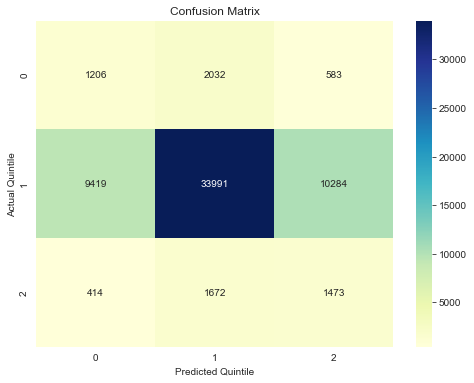

Accuracy: 60.04%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,bottom,10.924903,31.562418,16.231494,18.074795,6.256345
1,middle,90.173763,63.305025,74.387508,61.720208,87.916298
2,top,11.936791,41.388030,18.529467,20.204997,5.827357


In [314]:
class_predictions = classify_probabilities(0.39460854, 0.35043127, y_pred_prob)
plot_confusion_matrix(y_val, class_predictions)
classification_report(pd.Series(class_predictions), pd.Series(y_val), ['bottom', 'middle', 'top'])

In [213]:
pred.value_counts()

middle    61059
bottom       15
dtype: int64

---

Esto esta interesante, son metodos varios de calculo de seleccion de atributos:

In [33]:
kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_test_kbest = kbest.transform(X_test)
column_names_skb = X_train.columns[kbest.get_support()]
print(f"Columns selected by SelectKBest:\n -> {list(column_names_skb)}")

Columns selected by SelectKBest:
 -> ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta']


/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_34424/2680608447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'category'] = y_train.reset_index()['category']


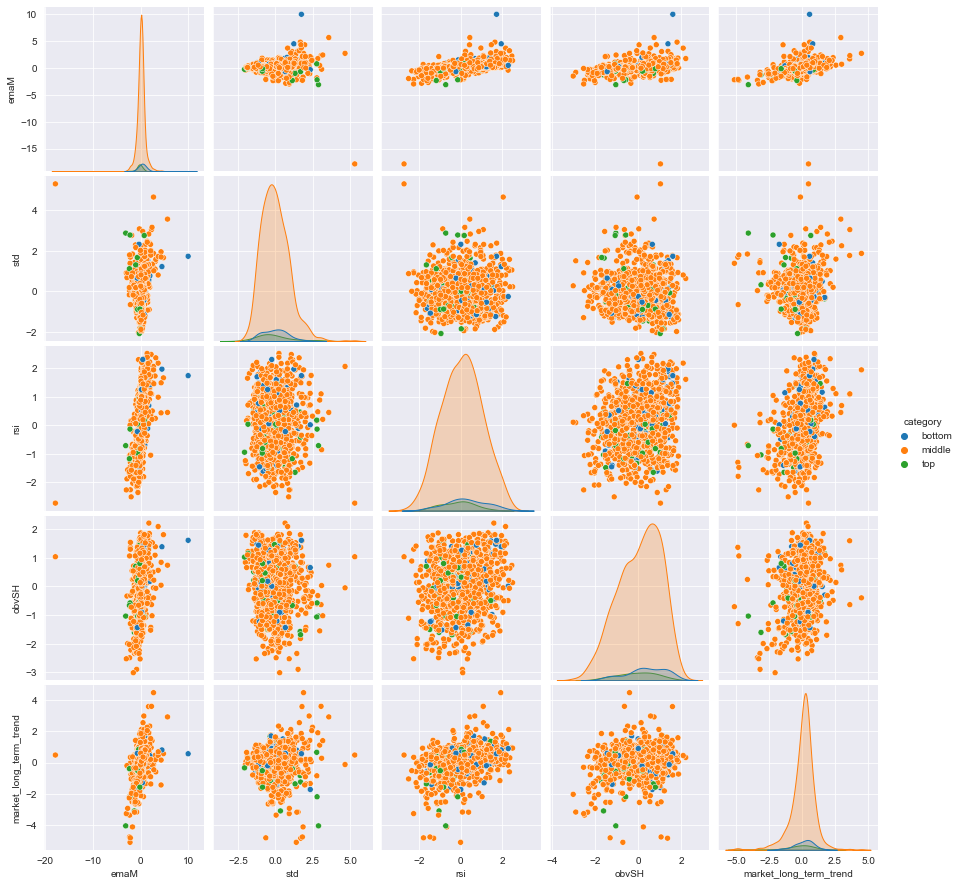

In [34]:
data = X_train[['emaM', 'std', 'rsi', 'obvSH', 'market_long_term_trend']]
data.loc[:, 'category'] = y_train.reset_index()['category']
sn.pairplot(data = data.sample(1000), hue='category')

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_34424/3919693507.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'category'] = y_train.reset_index()['category']


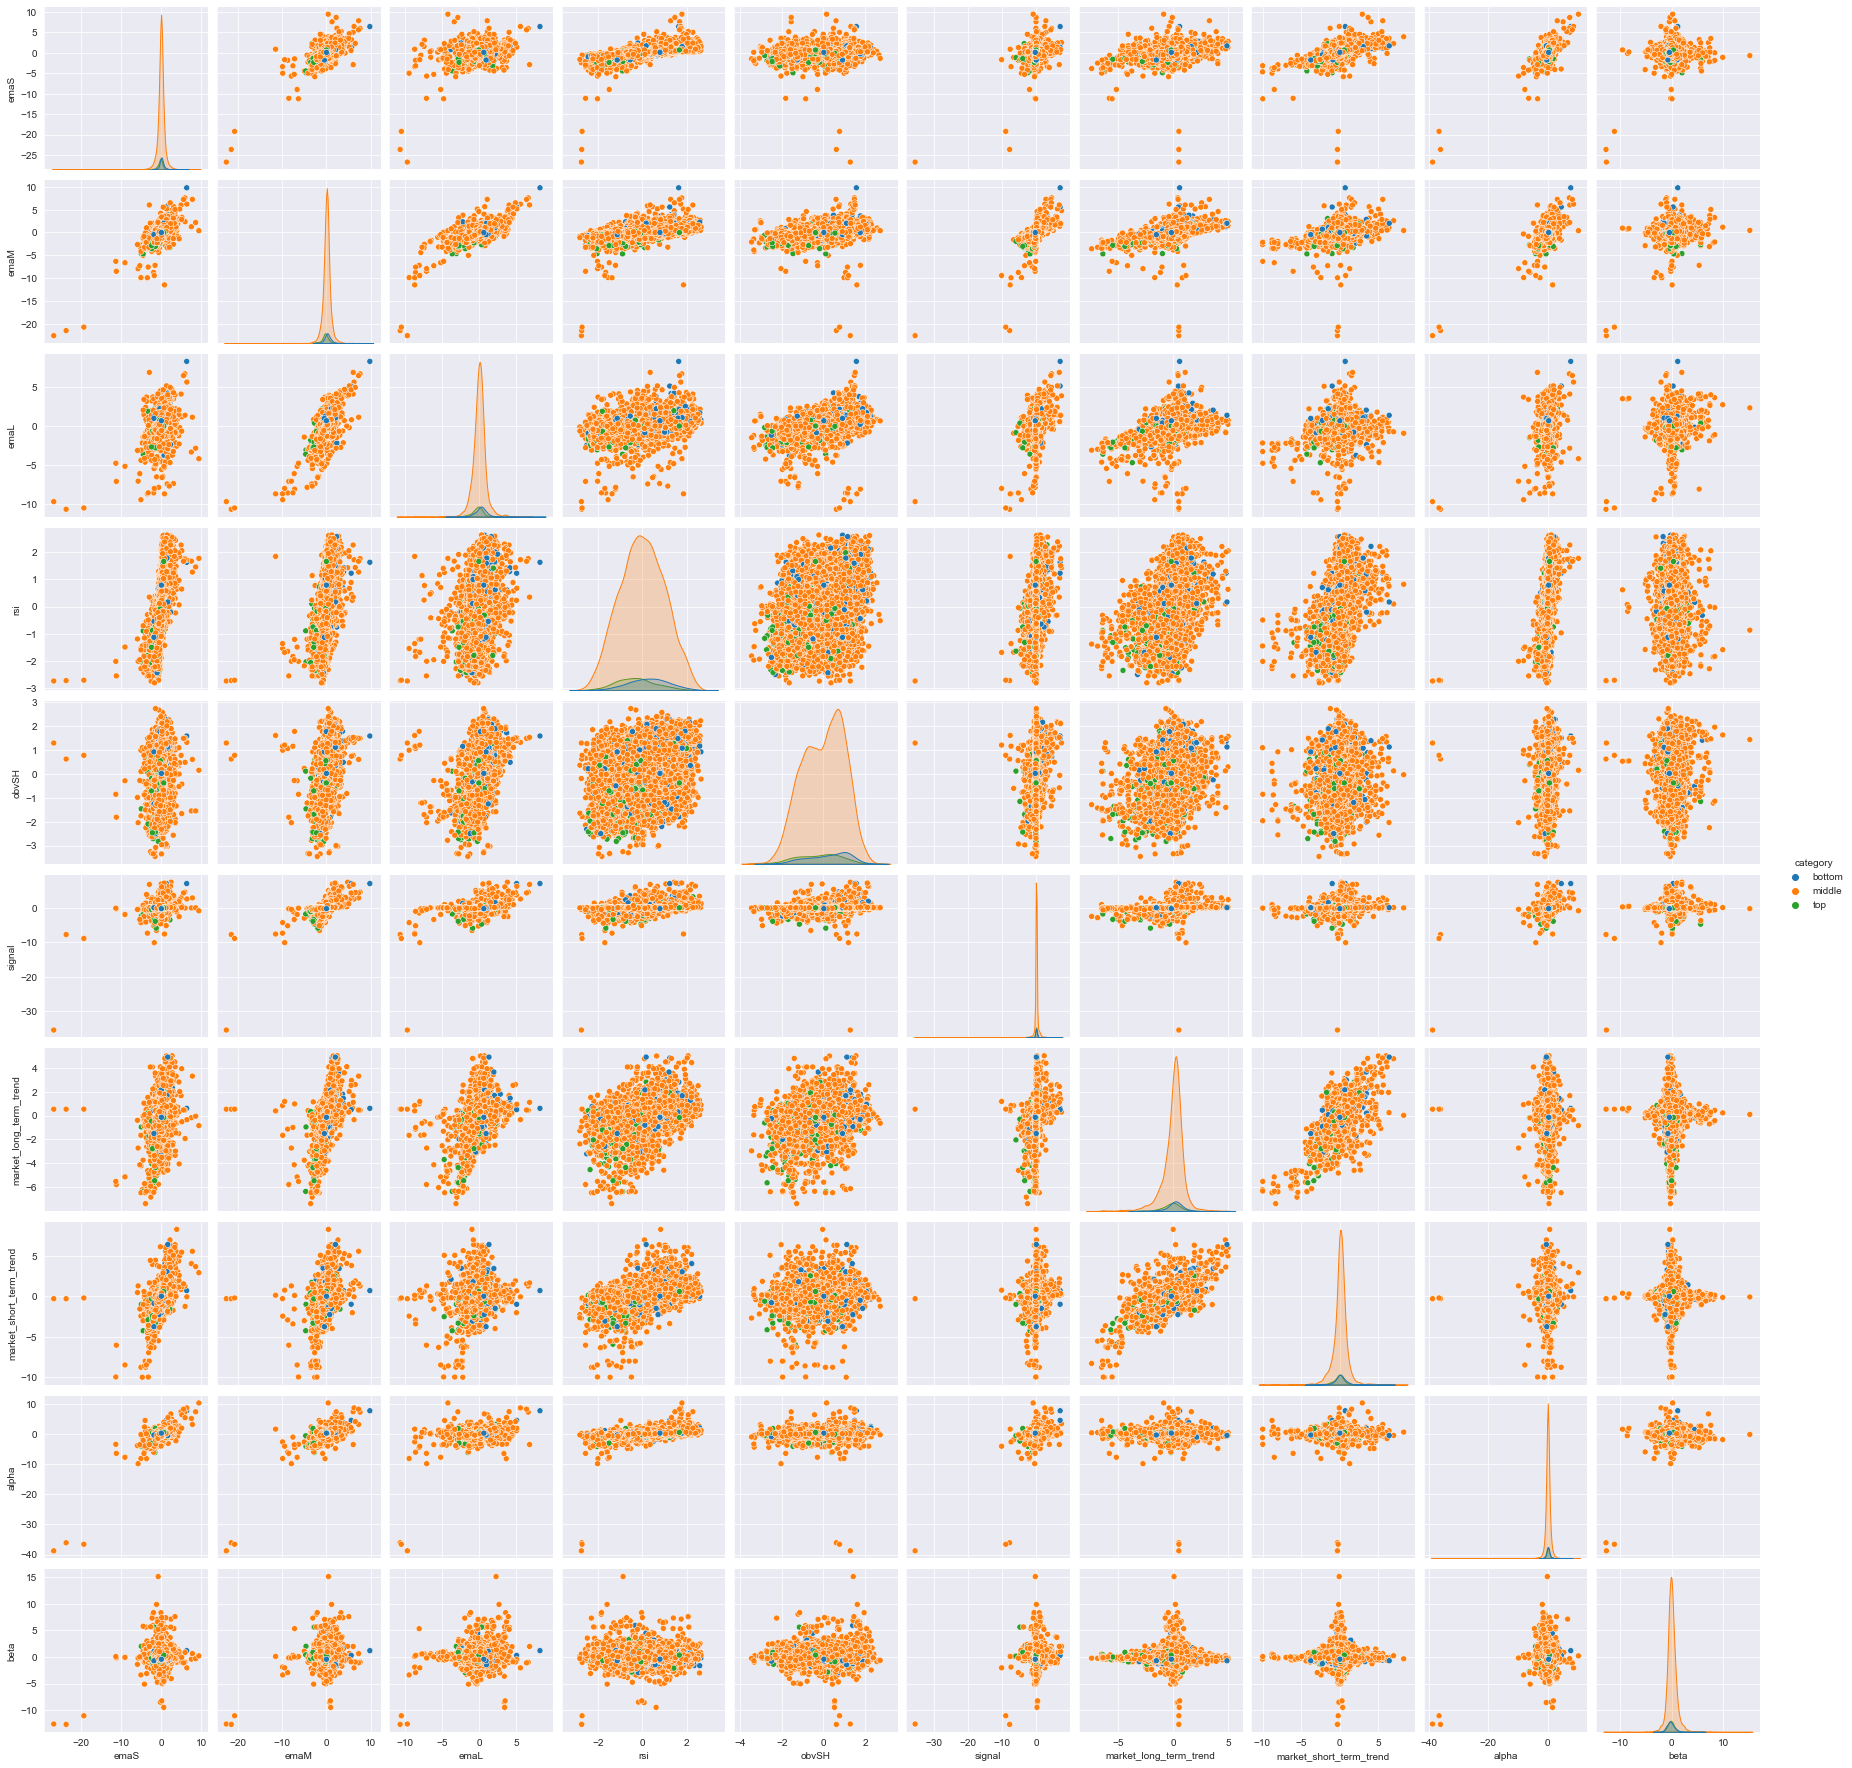

In [37]:
# cols = ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_correlation', 'beta']
# cols = ['emaM', 'emaL', 'std', 'obvSH', 'spy_value', 'time_embed_month_sin', 'time_embed_month_cos', 'time_embed_year_sin', 'time_embed_year_cos', 'market_long_term_trend']
data = X_train[column_names_skb]
data.loc[:, 'category'] = y_train.reset_index()['category']
sn.pairplot(data = data.sample(10000), hue='category')

In [38]:
model = RandomForestClassifier(
    max_depth=5,
    n_estimators=400,
    min_samples_split=2,
    verbose=True,
    n_jobs=-1
)

print("Fitting RF")
model.fit(X_train, y_train)

print("Selecting attrs")
selector = SelectFromModel(model, prefit=True, max_features=10)  # Choose the top 10 features
X_train_importance = selector.transform(X_train)
X_test_importance = selector.transform(X_test)

column_names_importance = X_train.columns[selector.get_support()]
print("Columns selected by feature importance:", column_names_importance)

Fitting RF


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s


Selecting attrs
Columns selected by feature importance: Index(['emaS', 'emaM', 'emaL', 'std', 'macd', 'signal', 'macds',
       'time_embed_year_sin', 'market_correlation', 'beta'],
      dtype='object')


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   16.7s finished
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [39]:
rfe = RFE(
    RandomForestClassifier(
        max_depth=5,
        n_estimators=50,
        min_samples_split=2,
        verbose=False,
        n_jobs=-1
    ),
    n_features_to_select=10
)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

column_names_rfe = X_train.columns[rfe.get_support()]
print("Columns selected by RFE:", column_names_rfe)

Columns selected by RFE: Index(['emaM', 'emaL', 'std', 'macd', 'signal', 'macds', 'spy_value',
       'time_embed_year_sin', 'market_correlation', 'beta'],
      dtype='object')


# All data

- selection 1: [
    'diff', 'pc', 'rsi', 'rsid', 'macds', 'financial_data_age', 'time_embed_week_sin',
    'time_embed_week_cos', 'time_embed_month_cos', 'market_change'
]
- selection 2: [
    'emaL', 'std', 'obvmS', 'obvmL', 'obvSH', 'lavgv', 'macd_std',
    'financial_data_age', 'spy_value', 'time_embed_year_cos'
]
- selection 3: [
    'emaL', 'std', 'obvmS', 'obvmL', 'ewm_26', 'financial_data_age',
    'spy_value', 'time_embed_year_sin', 'time_embed_year_cos', 'market_correlation'
]

---

# Only big ops
- selection 1: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha']
- selection 2: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_long_term_trend', 'beta']
- selection 3: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'macds', 'market_correlation', 'beta']
- selection cb + shap: ['v', 'n', 'diff', 'emaS', 'emaM', 'pc', 'rsi', 'rsid', 'ewm_26', 'macd', 'signal', 'macds', 'time_embed_day_sin', 'market_change', 'beta']

---

# Big ops w/ all data
- selection 1: ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta']
- selection 2: ['emaS', 'emaM', 'emaL', 'std', 'macd', 'signal', 'macds', 'time_embed_year_sin', 'market_correlation', 'beta']
- selection 3: ['emaM', 'emaL', 'std', 'macd', 'signal', 'macds', 'spy_value', 'time_embed_year_sin', 'market_correlation', 'beta']

---

In [35]:
!pip install scikit-optimize


     |████████████████████████████████| 100 kB 507 kB/s           


In [45]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define the parameter search space
params = {
    'n_estimators': Integer(10, 400),
    'max_depth': Integer(3, 30),
    'min_samples_split': Integer(2, 10),
}

# Define the model to optimize
model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=False
)

# Use BayesSearchCV to find the best parameters for the model
opt = BayesSearchCV(
    model,
    params,
    n_iter=20,
    cv=2,
    scoring='accuracy'
)
opt.fit(X_train, y_train)

# Print the best parameters and score
print("Best accuracy: {:.2f}".format(opt.best_score_))
print("Best Parameters: {}".format(opt.best_params_))

# Fit the final model with the best parameters on the full dataset
# final_model = opt.best_estimator_
# final_model.fit(X, y)


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best accuracy: 0.87
Best Parameters: OrderedDict([('max_depth', 30), ('min_samples_split', 2), ('n_estimators', 400)])


In [46]:
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=30,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    class_weight=None,
    verbose=True
)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.4s finished


RandomForestClassifier(max_depth=30, n_estimators=400, n_jobs=-1,
                       random_state=42, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:    0.1s finished


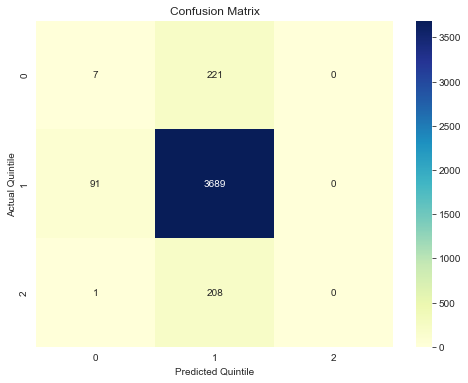

Accuracy: 87.65%


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,7.070707,3.070175,4.281346,0,0
1,1,89.582322,97.592593,93.416055,0,0
2,2,0.000000,0.000000,0.000000,0,0


In [47]:
y_pred = model.predict(X_val)
plot_confusion_matrix(y_val, y_pred)
classification_report(y_pred, y_val, [0, 1, 2])

In [56]:
optimizer = ModelOptimizer(
    model_class=RandomForestClassifier,
    pbounds={
        "n_estimators": (25, 500),
        "max_depth": (3, 30),
        "min_samples_split": (2, 10),
    },
    X=X_train,
    y=y_train,
    X_val=X_val,
    y_val=y_val,
    extra_params={
        'class_weight': 'balanced'
    },
    verbose=False
)
best_result = optimizer.optimize_model()
best_params = best_result["params"]
best_results = best_result["target"]

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.8153    | 13.11     | 9.606     | 372.7     |
| 2         | 0.8788    | 19.16     | 3.248     | 99.1      |
| 3         | 0.2469    | 4.568     | 8.929     | 310.5     |
| 4         | 0.8792    | 22.12     | 2.165     | 485.7     |
| 5         | 0.8792    | 25.48     | 3.699     | 111.4     |
| 6         | 0.4205    | 7.952     | 4.434     | 274.3     |
| 7         | 0.8685    | 14.66     | 4.33      | 315.6     |
| 8         | 0.353     | 6.766     | 4.337     | 199.0     |
| 9         | 0.8657    | 15.31     | 8.281     | 119.8     |
| 10        | 0.8719    | 16.88     | 6.739     | 47.06     |
| 11        | 0.876     | 17.61     | 7.165     | 46.65     |
| 12        | 0.8792    | 23.51     | 2.174     | 321.5     |
| 13        | 0.8792    | 26.66     | 2.0       | 308.2     |
| 14        | 0.2749    | 5.628     | 2.0       | 107.9     |
| 15    

KeyboardInterrupt: 

---

In [58]:
def custom_loss(y_true, y_pred):
    # Calculate the categorical cross-entropy for each sample
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Extract the indices of the samples where either the first or the last class is true
    indices = tf.where(tf.logical_or(tf.equal(y_true[:, 0], 1), tf.equal(y_true[:, -1], 1)))

    # Select the categorical cross-entropy values corresponding to the extracted indices
    selected_ce = tf.gather_nd(ce, indices)

    # Return the mean of the selected categorical cross-entropy values
    return tf.reduce_mean(selected_ce)


In [59]:
import numpy as np
import tensorflow as tf

# Validación de la custom_loss()

def test_custom_loss():
    # Define fixed y_true and y_pred tensors
    y_true = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]
    ])
    
    y_pred = np.array([
        [0.9, 0.05, 0.05],
        [0.1, 0.2, 0.1],
        [0.05, 0.05, 0.9],
        [0.9, 0.05, 0.05],
        [0.1, 0.2, 0.1]
    ])

    # Convert to tensors
    y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    # Compute the custom loss
    loss = custom_loss(y_true_tensor, y_pred_tensor)
    
    # Evaluate the result
    expected_loss = -np.log([0.9, 0.9]).mean()
    assert np.isclose(loss.numpy(), expected_loss, rtol=1e-5), f"Expected loss: {expected_loss}, got: {loss.numpy()}"

# Run the test
test_custom_loss()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-25 20:25:45.253968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 20:25:45.254685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


---

In [117]:
@dataclass
class RegressionHyperModel(HyperModel):
    input_dim: int
    output_dim: int
    
    def build(self, hp):
        model = Sequential()

        for i in range(hp.Int('layers', 1, 5)):
            if i == 0:
                model.add(Dense(
                    units=hp.Int('units%d' % i, min_value=16, max_value=512), 
                    activation=hp.Choice('activation%d' % i, values=['relu', 'selu']),
                    input_dim=self.input_dim
                ))
            else:
                model.add(Dense(
                    units=hp.Int('units%d' % i, min_value=16, max_value=512), 
                    activation=hp.Choice('activation%d' % i, values=['relu', 'selu']),
                ))
            model.add(Dropout(hp.Float('dropout%d' % i, 0, .6))),

        model.add(Dense(self.output_dim, activation='linear'))
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.05)),
            loss=custom_loss,
            metrics=['accuracy']
        )
        return model


In [118]:
def optimize_hyperparameters(X, y, input_dim, output_dim, class_weights):
    print("Optimizing hyperparameters...")
    tuner = kt.BayesianOptimization(
        RegressionHyperModel(input_dim, output_dim),
        objective='val_loss',
        max_trials=25,
        num_initial_points=5,
        seed=42,
        project_name='tuner_bayesian'
    )

    # Define an EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    tuner.search(
        X, y,
        epochs=100,
        batch_size=256,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stopping],
        class_weight=class_weights
    )
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hyperparameters

In [119]:
def print_best_hyperparameters(best_hyperparameters):
    print("\nBest Hyperparameters:")
    for key in best_hyperparameters.keys():
        print(f"{key}: {best_hyperparameters.get(key)}")

In [108]:
train_encoded = pd.get_dummies(y_train)
val_encoded = pd.get_dummies(y_val)
test_encoded = pd.get_dummies(y_test)
train_encoded, val_encoded = train_encoded.align(val_encoded, join='outer', axis=1, fill_value=0)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='outer', axis=1, fill_value=0)

In [109]:
class_weights = {}
for k, v in dict(train_encoded.value_counts()).items():
    class_weights[np.argmax(list(k))] = 1 / v

class_weights

{1: 9.875762902684232e-06, 0: 0.0001408649105507818, 2: 0.00014988009592326138}

In [120]:
optimize_hyperparameters(X_train, train_encoded, X_train.shape[1], train_encoded.shape[1], class_weights)

Trial 25 Complete [00h 01m 12s]
val_loss: 8.171006982138351e-08

Best val_loss So Far: 8.171006982138351e-08
Total elapsed time: 13h 20m 58s
INFO:tensorflow:Oracle triggered exit


In [121]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=custom_loss,
    # loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               33792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [122]:
from sklearn.preprocessing import OneHotEncoder

train_encoded = pd.get_dummies(y_train)
val_encoded = pd.get_dummies(y_val)
test_encoded = pd.get_dummies(y_test)
train_encoded, val_encoded = train_encoded.align(val_encoded, join='outer', axis=1, fill_value=0)
train_encoded, test_encoded = train_encoded.align(test_encoded, join='outer', axis=1, fill_value=0)

history = model.fit(
    X_train,
    train_encoded,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, val_encoded),
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100


2023-04-26 17:08:30.332950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.0749

2023-04-26 17:08:36.176081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


450/450 [==============================] - 9s 19ms/step - loss: 0.6898 - accuracy: 0.0749 - val_loss: 0.5944 - val_accuracy: 0.0803
Epoch 2/100
450/450 [==============================] - 7s 15ms/step - loss: 0.6071 - accuracy: 0.0805 - val_loss: 0.5908 - val_accuracy: 0.0810
Epoch 3/100
450/450 [==============================] - 7s 15ms/step - loss: 0.5878 - accuracy: 0.0826 - val_loss: 0.5824 - val_accuracy: 0.0821
Epoch 4/100
450/450 [==============================] - 7s 15ms/step - loss: 0.5699 - accuracy: 0.0840 - val_loss: 0.6072 - val_accuracy: 0.0814
Epoch 5/100
450/450 [==============================] - 7s 15ms/step - loss: 0.5528 - accuracy: 0.0862 - val_loss: 0.6018 - val_accuracy: 0.0816
Epoch 6/100
450/450 [==============================] - 7s 16ms/step - loss: 0.5395 - accuracy: 0.0872 - val_loss: 0.6075 - val_accuracy: 0.0807
Epoch 7/100
450/450 [==============================] - 7s 16ms/step - loss: 0.5286 - accuracy: 0.0880 - val_loss: 0.6259 - val_accuracy: 0.0806
Epoc

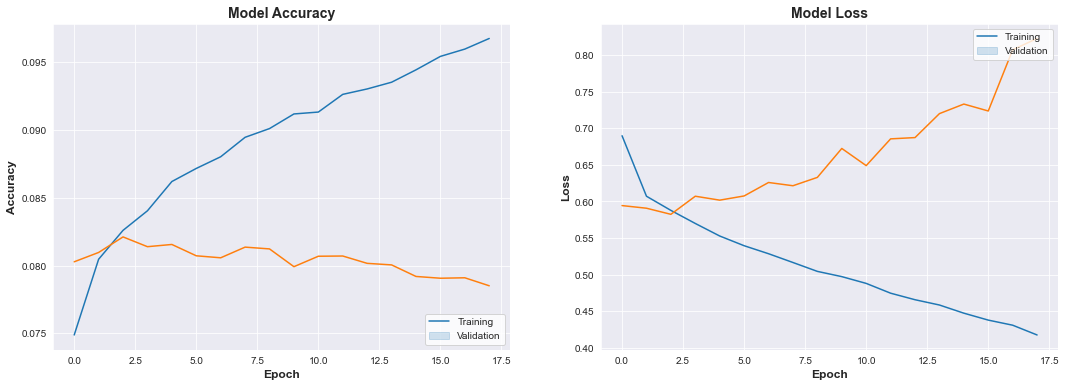

In [123]:
plot_history(history)

2023-04-26 17:11:08.293354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


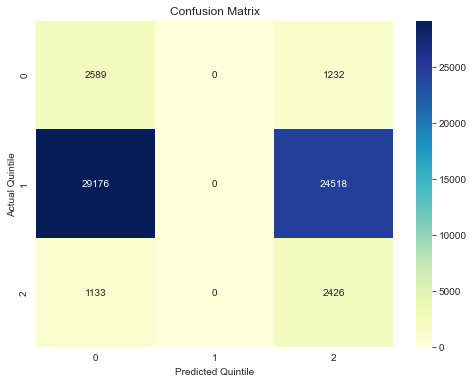

In [124]:
plot_confusion_matrix(
    np.argmax(val_encoded.to_numpy(), axis=1),
    np.argmax(model.predict(X_val), axis=1)
)

In [125]:
predictions_cat = np.argmax(model.predict(X_val), axis=1)
targets_cat = np.argmax(val_encoded.to_numpy(), axis=1)

classification_report(predictions_cat, targets_cat, [0, 1, 2])

Accuracy: 8.21%


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,7.869779,67.757132,14.101691,53.865802,6.256345
1,1,0.000000,0.000000,0.000000,0.000000,87.916298
2,2,8.610165,68.165215,15.289113,46.134198,5.827357


In [192]:
predictions_cat = np.argmax(model.predict(X_test), axis=1)
targets_cat = np.argmax(test_encoded.to_numpy(), axis=1)

classification_report(predictions_cat, targets_cat, [0, 1, 2])

Accuracy: 8.30%


/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,7.863104,74.214721,14.219627,53.873532,5.707940
1,1,0.000000,0.000000,0.000000,0.000000,88.123846
2,2,8.806637,65.856833,15.535769,46.126468,6.168214


---

# Detección de cuando predecir

In [41]:
model_hv = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(512, activation='selu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_hv.compile(
    optimizer=Adam(learning_rate=0.000075),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_hv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               33792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [42]:
from sklearn.preprocessing import OneHotEncoder

history = model_hv.fit(
    X_train_hv,
    y_train_hv,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_hv, y_val_hv),
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100


2023-04-24 23:59:24.400600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.5173

2023-04-24 23:59:26.016849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 2s 15ms/step - loss: 0.7288 - accuracy: 0.5173 - val_loss: 0.6939 - val_accuracy: 0.5396
Epoch 2/100
108/108 [==============================] - 1s 14ms/step - loss: 0.6977 - accuracy: 0.5387 - val_loss: 0.6885 - val_accuracy: 0.5507
Epoch 3/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6879 - accuracy: 0.5536 - val_loss: 0.6841 - val_accuracy: 0.5578
Epoch 4/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6837 - accuracy: 0.5589 - val_loss: 0.6833 - val_accuracy: 0.5563
Epoch 5/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6801 - accuracy: 0.5651 - val_loss: 0.6806 - val_accuracy: 0.5641
Epoch 6/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6741 - accuracy: 0.5744 - val_loss: 0.6792 - val_accuracy: 0.5706
Epoch 7/100
108/108 [==============================] - 1s 13ms/step - loss: 0.6730 - accuracy: 0.5792 - val_loss: 0.6798 - val_accuracy: 0.5642
Epoc

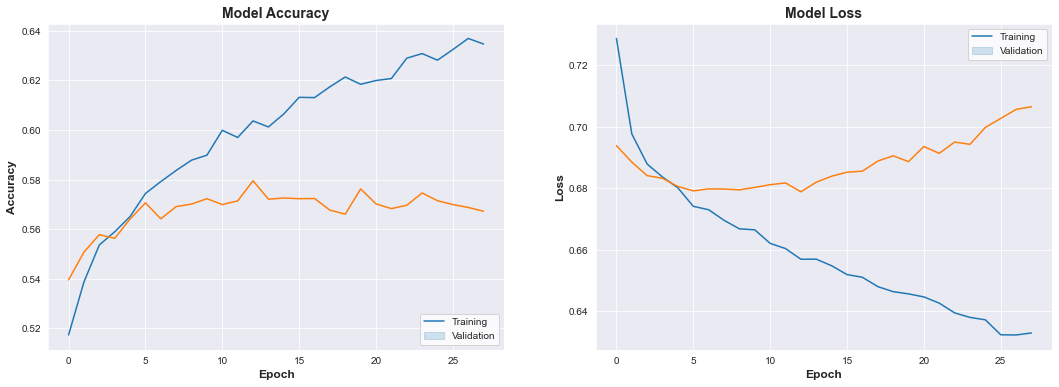

In [43]:
plot_history(history)

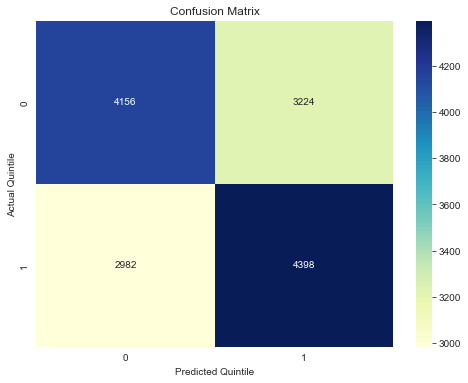

Accuracy: 57.95%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,58.223592,56.314363,57.253065,48.360434,50.0
1,1,57.701391,59.593496,58.632182,51.639566,50.0


In [63]:
pred = np.where(model_hv.predict(X_val_hv) >= 0.5, 1, 0).reshape(X_val_hv.shape[0],)
targ = y_val_hv.to_numpy()

plot_confusion_matrix(targ, pred)
classification_report(pred, targ, [0, 1])

In [271]:
def compute_recall(predictions, targets, threshold, value):
    pred = np.where(predictions >= threshold, 1, 0).reshape(targets.shape[0],)
    targ = targets

    return ((targ == value) & (pred == value)).sum() / (targ == value).sum()

def compute_precision(predictions, targets, threshold, value):
    pred = np.where(predictions >= threshold, 1, 0).reshape(targets.shape[0],)
    targ = targets

    return ((targ == value) & (pred == value)).sum() / (pred == value).sum()

def compute_frequencies(predictions, targets, threshold, value):
    pred = np.where(predictions >= threshold, 1, 0).reshape(targets.shape[0],)
    targ = targets

    return (pred == value).sum() / len(pred)

def compute_idek(predictions, targets, threshold, value):
    pred = np.where(predictions >= threshold, 1, 0).reshape(targets.shape[0],)
    targ = targets

    return (pred == value).sum() / (targ == value).sum()

In [167]:
predictions = model_hv.predict(X_test)

/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_31442/1977189920.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ((targ == value) & (pred == value)).sum() / (pred == value).sum()


Found threshold at 0.60
Value for precision is 0.885
Value for recall is 0.944
Value for freq is 0.059
Value for idek is 0.501


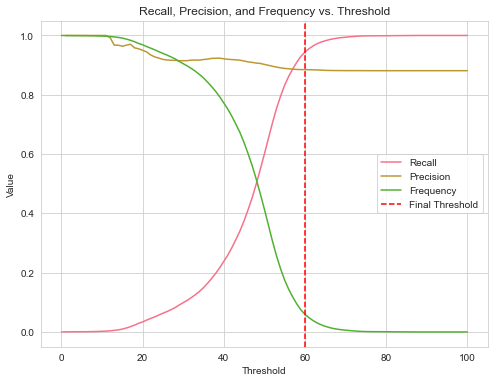

In [168]:
targets = y_test_hv
objective = 0.94

final_threshold = 0.5
found = False

recalls = []
precisions = []
freq = []
idek = []
for v in range(0, 101, 1):
    th = v / 100

    recalls.append(compute_recall(predictions, targets, th, 0))
    precisions.append(compute_precision(predictions, targets, th, 0))
    freq.append(compute_frequencies(predictions, targets, th, 1))
    idek.append(compute_idek(predictions, targets, th, 1))

    if not found and (objective <= recalls[-1]):
        print(f"Found threshold at {th:.2f}")
        print(f"Value for precision is {precisions[-1]:.3f}")
        print(f"Value for recall is {recalls[-1]:.3f}")
        print(f"Value for freq is {freq[-1]:.3f}")
        print(f"Value for idek is {idek[-1]:.3f}")
        final_threshold = th
        found = True


plt.figure(figsize=(8,6))
sn.lineplot(x=range(len(recalls)), y=recalls, label='Recall')
sn.lineplot(x=range(len(precisions)), y=precisions, label='Precision')
sn.lineplot(x=range(len(freq)), y=freq, label='Frequency')
plt.axvline(x=100 * final_threshold, color='red', linestyle='--', label='Final Threshold')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Recall, Precision, and Frequency vs. Threshold')
plt.legend()

plt.show()

**Objetivo:** reducir en un factor x15 o x18 la cantidad de 'middle' por lo tanto se necesita un recall de almenos el 94%

In [193]:
predictions_hv = np.where(predictions >= 0.60, 1, 0).reshape(targets.shape[0],)

In [194]:
pd.Series(predictions_cat).loc[predictions_hv == 0] = 1

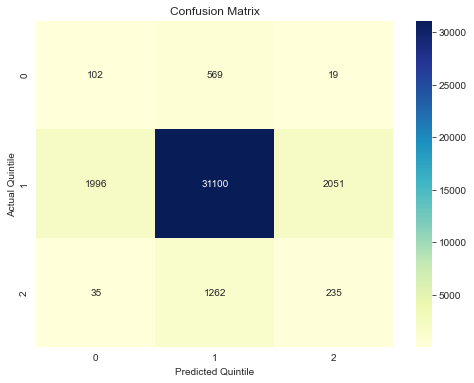

Accuracy: 84.13%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,14.782609,4.781997,7.226355,1.846450,5.707940
1,1,88.485504,94.439889,91.365786,94.053895,88.123846
2,2,15.339426,10.195228,12.249153,4.099655,6.168214


In [195]:
plot_confusion_matrix(predictions_cat, targets_cat)
classification_report(predictions_cat, targets_cat, [0, 1, 2])

---

In [24]:
models = {
    "xgboost": {
        "model": xgb.XGBClassifier,
        "pbounds": {
            "max_depth": (3, 30),
            "learning_rate": (0.001, 0.1),
        },
        "columns": X_train.columns
        # "columns": ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation']
    },
    "random_forest": {
        "model": RandomForestClassifier,
        "pbounds": {
            "n_estimators": (25, 400),
            "max_depth": (3, 30),
            "min_samples_split": (2, 10),
        },
        "columns": X_train.columns
        # "columns": ['emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal', 'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation']
    },
    "catboost_full": {
        "model": cat.CatBoostClassifier,
        "pbounds": {
            "depth": (3, 10),
            "learning_rate": (0.005, 0.6),
        },
        "columns": X_train.columns
    },
    "catboost": {
        "model": cat.CatBoostClassifier,
        "pbounds": {
            "depth": (3, 10),
            "learning_rate": (0.005, 0.6),
        },
        "columns": [
            'emaS', 'emaM', 'emaL', 'rsi', 'obvSH', 'macd', 'signal',
            'market_long_term_trend', 'market_short_term_trend', 'alpha', 'beta', 'market_correlation'
        ]
    },
}

In [418]:
best_params, best_results = {}, {}
for model_name, model_info in models.items():
    print(f"Optimizing {model_name}...")

    optimizer = ModelOptimizer(
        model_class=model_info["model"],
        pbounds=model_info["pbounds"],
        X=X_train[model_info["columns"]],
        y=y_train,
        X_val=X_val[model_info["columns"]],
        y_val=y_val,
        verbose=False,
        force_params=model_info.get("force_types")
    )
    best_result = optimizer.optimize_model()
    
    best_params[model_name] = best_result["params"]
    best_results[model_name] = best_result["target"]


Optimizing xgboost...
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.4398    | 0.03808   | 28.67     |
| 2         | 0.4537    | 0.07347   | 19.16     |
| 3         | 0.479     | 0.01645   | 7.212     |
| 4         | 0.4532    | 0.00675   | 26.39     |
| 5         | 0.4237    | 0.06051   | 22.12     |
| 6         | 0.4512    | 0.003038  | 29.19     |
| 7         | 0.4671    | 0.08341   | 8.733     |
| 8         | 0.4715    | 0.019     | 7.952     |
| 9         | 0.4564    | 0.03112   | 17.17     |
| 10        | 0.4795    | 0.04376   | 10.86     |
| 11        | 0.4849    | 0.001     | 5.414     |
| 12        | 0.4922    | 0.08914   | 3.25      |
| 13        | 0.4728    | 0.1       | 13.21     |
| 14        | 0.4874    | 0.0957    | 4.155     |
| 15        | 0.4914    | 0.001     | 3.0       |
| 16        | 0.4752    | 0.001     | 11.94     |
| 17        | 0.4791    | 0.001     | 14.94     |
| 18        | 0.4914    | 0.

In [32]:
model = cat.CatBoostClassifier(
    iterations=20000,
    early_stopping_rounds=300,
    learning_rate=0.128,
    depth=9,
    eval_metric='Accuracy',
    random_seed=42
)

summary = model.select_features(
    cat.Pool(X_train, y_train),
    eval_set=cat.Pool(X_val, y_val),
    features_for_select='0-64',
    num_features_to_select=15,
    steps=24,
    algorithm=cat.EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=cat.EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [35]:
summary['selected_features_names']

['v',
 'n',
 'diff',
 'emaS',
 'emaM',
 'pc',
 'rsi',
 'rsid',
 'ewm_26',
 'macd',
 'signal',
 'macds',
 'time_embed_day_sin',
 'market_change',
 'beta']

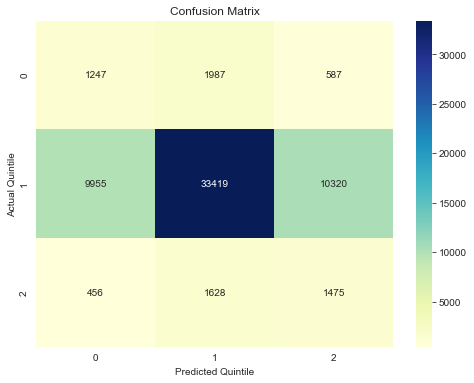

In [243]:
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_xlabel("Predicted Quintile")
ax.set_ylabel("Actual Quintile")
ax.set_title("Confusion Matrix")
plt.show()

In [249]:
def balanced_batch_generator(X, y, batch_size):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    num_classes = len(unique_classes)

    while True:
        # Shuffle the data
        shuffled_indices = np.random.permutation(len(X))
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        # Create indices for each class
        class_indices = [np.where(y_shuffled == cls)[0] for cls in unique_classes]

        for i in range(0, len(X), batch_size):
            # Select batch_size // num_classes samples from each class
            batch_indices = []
            for indices in class_indices:
                batch_indices.extend(np.random.choice(indices, size=batch_size // num_classes, replace=True))

            # Shuffle the indices to mix the classes in the batch
            np.random.shuffle(batch_indices)

            # Yield the batch data
            X_batch = X_shuffled[batch_indices]
            y_batch = y_shuffled[batch_indices]
            yield X_batch, y_batch

In [266]:
model_hv = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_hv.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_hv.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               16896     
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                

In [267]:
batch_size = 512
epochs = 100

history = model_hv.fit(
    balanced_batch_generator(X_train.to_numpy(), y_train_hv.to_numpy(), batch_size),
    steps_per_epoch=(X_train.shape[0] // batch_size),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=balanced_batch_generator(X_val.to_numpy(), y_val_hv.to_numpy(), batch_size),
    validation_steps=(X_val.shape[0] // batch_size),
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100


2023-04-26 19:51:35.003244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/224 [============================>.] - ETA: 0s - loss: 0.7365 - accuracy: 0.5039

2023-04-26 19:51:37.079966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


224/224 [==============================] - 3s 10ms/step - loss: 0.7363 - accuracy: 0.5039 - val_loss: 0.6993 - val_accuracy: 0.5175
Epoch 2/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7216 - accuracy: 0.5137 - val_loss: 0.6942 - val_accuracy: 0.5272
Epoch 3/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7155 - accuracy: 0.5140 - val_loss: 0.6906 - val_accuracy: 0.5326
Epoch 4/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7099 - accuracy: 0.5162 - val_loss: 0.6891 - val_accuracy: 0.5348
Epoch 5/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7059 - accuracy: 0.5204 - val_loss: 0.6884 - val_accuracy: 0.5350
Epoch 6/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7019 - accuracy: 0.5227 - val_loss: 0.6879 - val_accuracy: 0.5379
Epoch 7/100
224/224 [==============================] - 2s 9ms/step - loss: 0.7008 - accuracy: 0.5216 - val_loss: 0.6865 - val_accuracy: 0.5425
Epoch 8/10

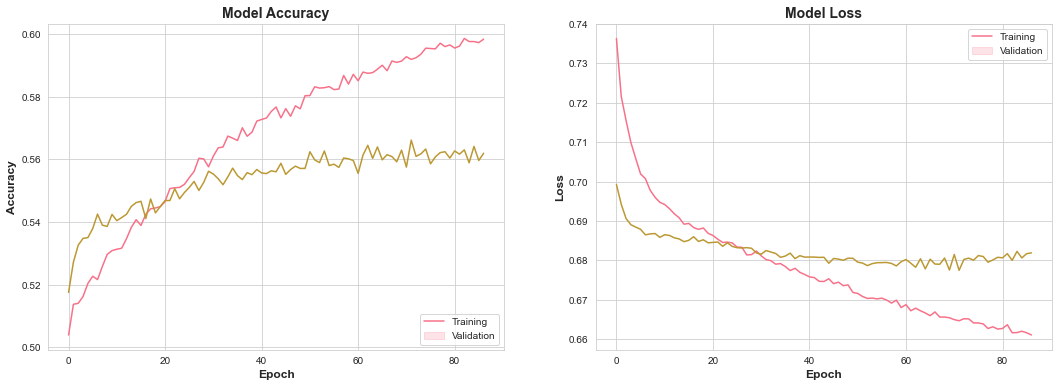

In [268]:
plot_history(history)

2023-04-26 19:55:05.303681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


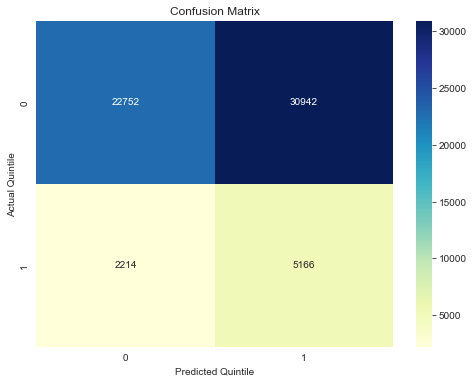

Accuracy: 45.71%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,91.131939,42.37345,57.848970,40.878279,87.916298
1,1,14.307079,70.00000,23.758278,59.121721,12.083702


In [269]:
pred = np.where(model_hv.predict(X_val_hv) >= 0.5, 1, 0).reshape(X_val_hv.shape[0],)
targ = y_val_hv.to_numpy()

plot_confusion_matrix(targ, pred)
classification_report(pred, targ, [0, 1])

In [283]:
predictions = model_hv.predict(X_val_hv)
targets = y_val_hv

Found threshold at 0.63
Value for precision is 18.57%
Value for recall is 94.77%
Value for freq is 5.64%
Value for idek is 0.467


/var/folders/4z/l7kc3ncn7g3628qd59lkh1km0000gn/T/ipykernel_34424/1977189920.py:11: RuntimeWarning: invalid value encountered in long_scalars
  return ((targ == value) & (pred == value)).sum() / (pred == value).sum()


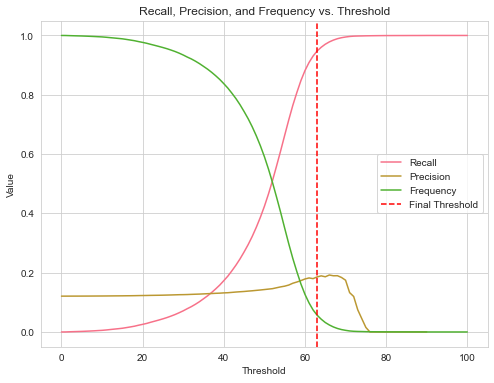

In [290]:
objective = 0.94

final_threshold = 0.5
found = False

recalls = []
precisions = []
freq = []
idek = []

minv, maxv = 0, 100
for v in range(minv, maxv + 1, 1):
    th = (v - minv) / (maxv - minv)

    recalls.append(compute_recall(predictions, targets, th, 0))
    precisions.append(compute_precision(predictions, targets, th, 1))
    freq.append(compute_frequencies(predictions, targets, th, 1))
    idek.append(compute_idek(predictions, targets, th, 1))

    if not found and (objective <= recalls[-1]):
        print(f"Found threshold at {th:.2f}")
        print(f"Value for precision is {100 * precisions[-1]:.2f}%")
        print(f"Value for recall is {100 * recalls[-1]:.2f}%")
        print(f"Value for freq is {100 * freq[-1]:.2f}%")
        print(f"Value for idek is {idek[-1]:.3f}")
        final_threshold = th
        found = True


plt.figure(figsize=(8,6))
sn.lineplot(x=range(len(recalls)), y=recalls, label='Recall')
sn.lineplot(x=range(len(precisions)), y=precisions, label='Precision')
sn.lineplot(x=range(len(freq)), y=freq, label='Frequency')
plt.axvline(x=100 * final_threshold, color='red', linestyle='--', label='Final Threshold')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Recall, Precision, and Frequency vs. Threshold')
plt.legend()

plt.show()

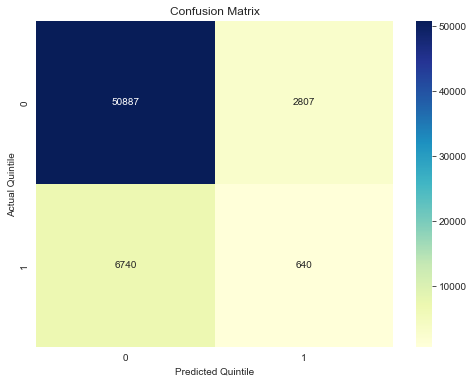

Accuracy: 84.37%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,0,88.304094,94.772228,91.423900,94.356027,87.916298
1,1,18.566870,8.672087,11.822296,5.643973,12.083702


In [291]:
pred_hv = np.where(predictions >= 0.63, 1, 0).reshape(X_val_hv.shape[0],)
targ_hv = y_val_hv.to_numpy()

plot_confusion_matrix(targ, pred)
classification_report(pred, targ, [0, 1])

In [321]:
hv = np.where(model_hv.predict(X_val_hv) >= 0.63, 1, 0).reshape(X_val_hv.shape[0],)
cp = class_predictions.copy()

In [322]:
pd.Series(cp).loc[hv == 0] = 'middle'

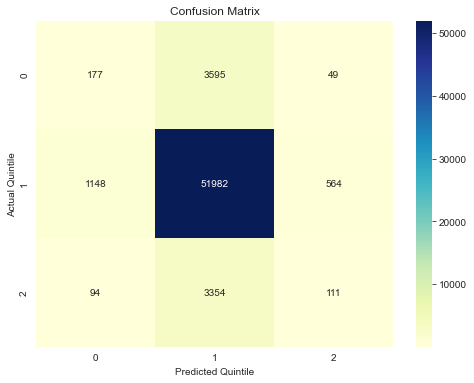

Accuracy: 85.58%


,Class,Precision,Recall,F1-score,Prediction Proportion,Target Proportion
0,bottom,12.473573,4.632295,6.755725,2.323411,6.256345
1,middle,88.208244,96.811562,92.309878,96.491142,87.916298
2,top,15.331492,3.118854,5.183283,1.185447,5.827357


In [325]:
plot_confusion_matrix(y_val, cp)
classification_report(cp, y_val, ['bottom', 'middle', 'top'])